In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, Bounds, NonlinearConstraint
from matplotlib.ticker import MultipleLocator



# add the directory where fixed_income_derivatives.py is located to the system path
sys.path.append(os.path.abspath("../../Files"))

# import own module
import fixed_income_derivatives_E2024 as fid

%load_ext autoreload
%autoreload 2

# Problem 1
Imagine that todays date is Jauary 1. 2017 and the 3M LIBOR fixing has just been announced. You are working for a financial institution and have been approached by a client who needs to pay 3M LIBOR
on a loan of 1 British pound on April 1. 2017, July 1. 2017, October 1. 2017, January 1. 2018, April 1. 2018 July 1. 2018, October 1. 2018 and finally on January 1. 2019. Each of these payments equal the fixing announced exactly 3 months prior. The client wishes to protect himself from 3M LIBOR exceeding $0.045$ and your job will be to quote a risk-neutral price on an interest rate cap with a strike of $R = 0.045$. As always, assume that the year has 360 days, that each month has 30 days and that there is no credit risk. Your trusted quant coworker has extracted ZCB prices for you and they are

In [2]:
delta = 0.25 # quarterly periods
M = 9 # 9 periods incl 0 (today)
p = np.array([1,0.99228605, 0.98417493, 0.97571048, 0.96693366, 0.95788267, 0.94859299, 0.93909755, 0.92942683])
T = np.array([m*delta for m in range(M)]) # time in years

Also, you can see from market data that Black Implied Volatilities, $\sigma_i$, for caplets on 3M with maturities $T_i$ and resettlement date one quarter earlier with a strike of $0.045$ are

In [3]:
R = 0.045
sigma_market = np.array([np.nan,np.nan,0.15,0.19,0.23,0.27,0.3,0.33,0.36])

#### (a) Find the spot rates and 3M forward rates corresponding to the ZCB prices and plot these term structures.

In [4]:
r, f_3m = np.zeros([M]), np.zeros([M])
for i in range(1,M):
    r[i] = -np.log(p[i])/T[i]
    f_3m[i] = -(np.log(p[i])-np.log(p[i-1]))/(T[i]-T[i-1])

print(f'r: \n {r}')
print(f'f_3m: \n {f_3m}')

r: 
 [0.         0.03097543 0.03190325 0.03278583 0.03362539 0.03442399
 0.03518364 0.03590624 0.0365936 ]
f_3m: 
 [0.         0.03097543 0.03283107 0.03455101 0.03614406 0.03761837
 0.03898189 0.04024185 0.04140511]


#### (b) Explain why there is no caplet available for a maturity of $T = 0.25$ and resettlement at $T = 0$, and compute the caplet prices corresponding to the remaining maturities

#### (c) Compute the price of the cap that would prevent the client from ever paying more than $0.045$ on his floating rate obligation.

In [5]:
alpha, L, price_caplet = np.zeros([M]), np.zeros([M]), np.zeros([M])
for i in range(1,M):
    alpha[i] = T[i]-T[i-1]
    L[i] = (1/alpha[i])*(p[i-1] - p[i])/p[i]
    if i > 1:
        price_caplet[i] = fid.black_caplet_price(sigma_market[i],T[i],R,alpha[i],p[i],L[i],type = 'call')
price_cap = sum(price_caplet[2:])
print(f"cap price: {price_cap} GBP.")

cap price: 0.004535004609365829 GBP.


#### (d) The client would like to not pay for this cap upfront but rather pay a fixed premium at the dates where he pays regular interest on his floating rate obligation. Find the premium that the client would have to pay to your bank quarterly starting at April 1. 2017 and ending January 1. 2019 should he enter into the interest rate cap

In [6]:
accrual_factor = 0
for i in range(1,M):
    accrual_factor += alpha[i]*p[i]
premium = price_cap/accrual_factor
print(f"premium: {premium} GBP, premium: {int(premium*10000)} bps.")

premium: 0.00235765148256218 GBP, premium: 23 bps.


#### (e) Alternatively, you can offer the client to pay a fixed rate by offering him an interest rate swap. What would be the fixed rate that the client would need to pay instead of 3M LIBOR?

In [7]:
# e)
R = (1-p[M-1])/accrual_factor
print(f"Par swap rate: {R}.")

Par swap rate: 0.03668947514099221.


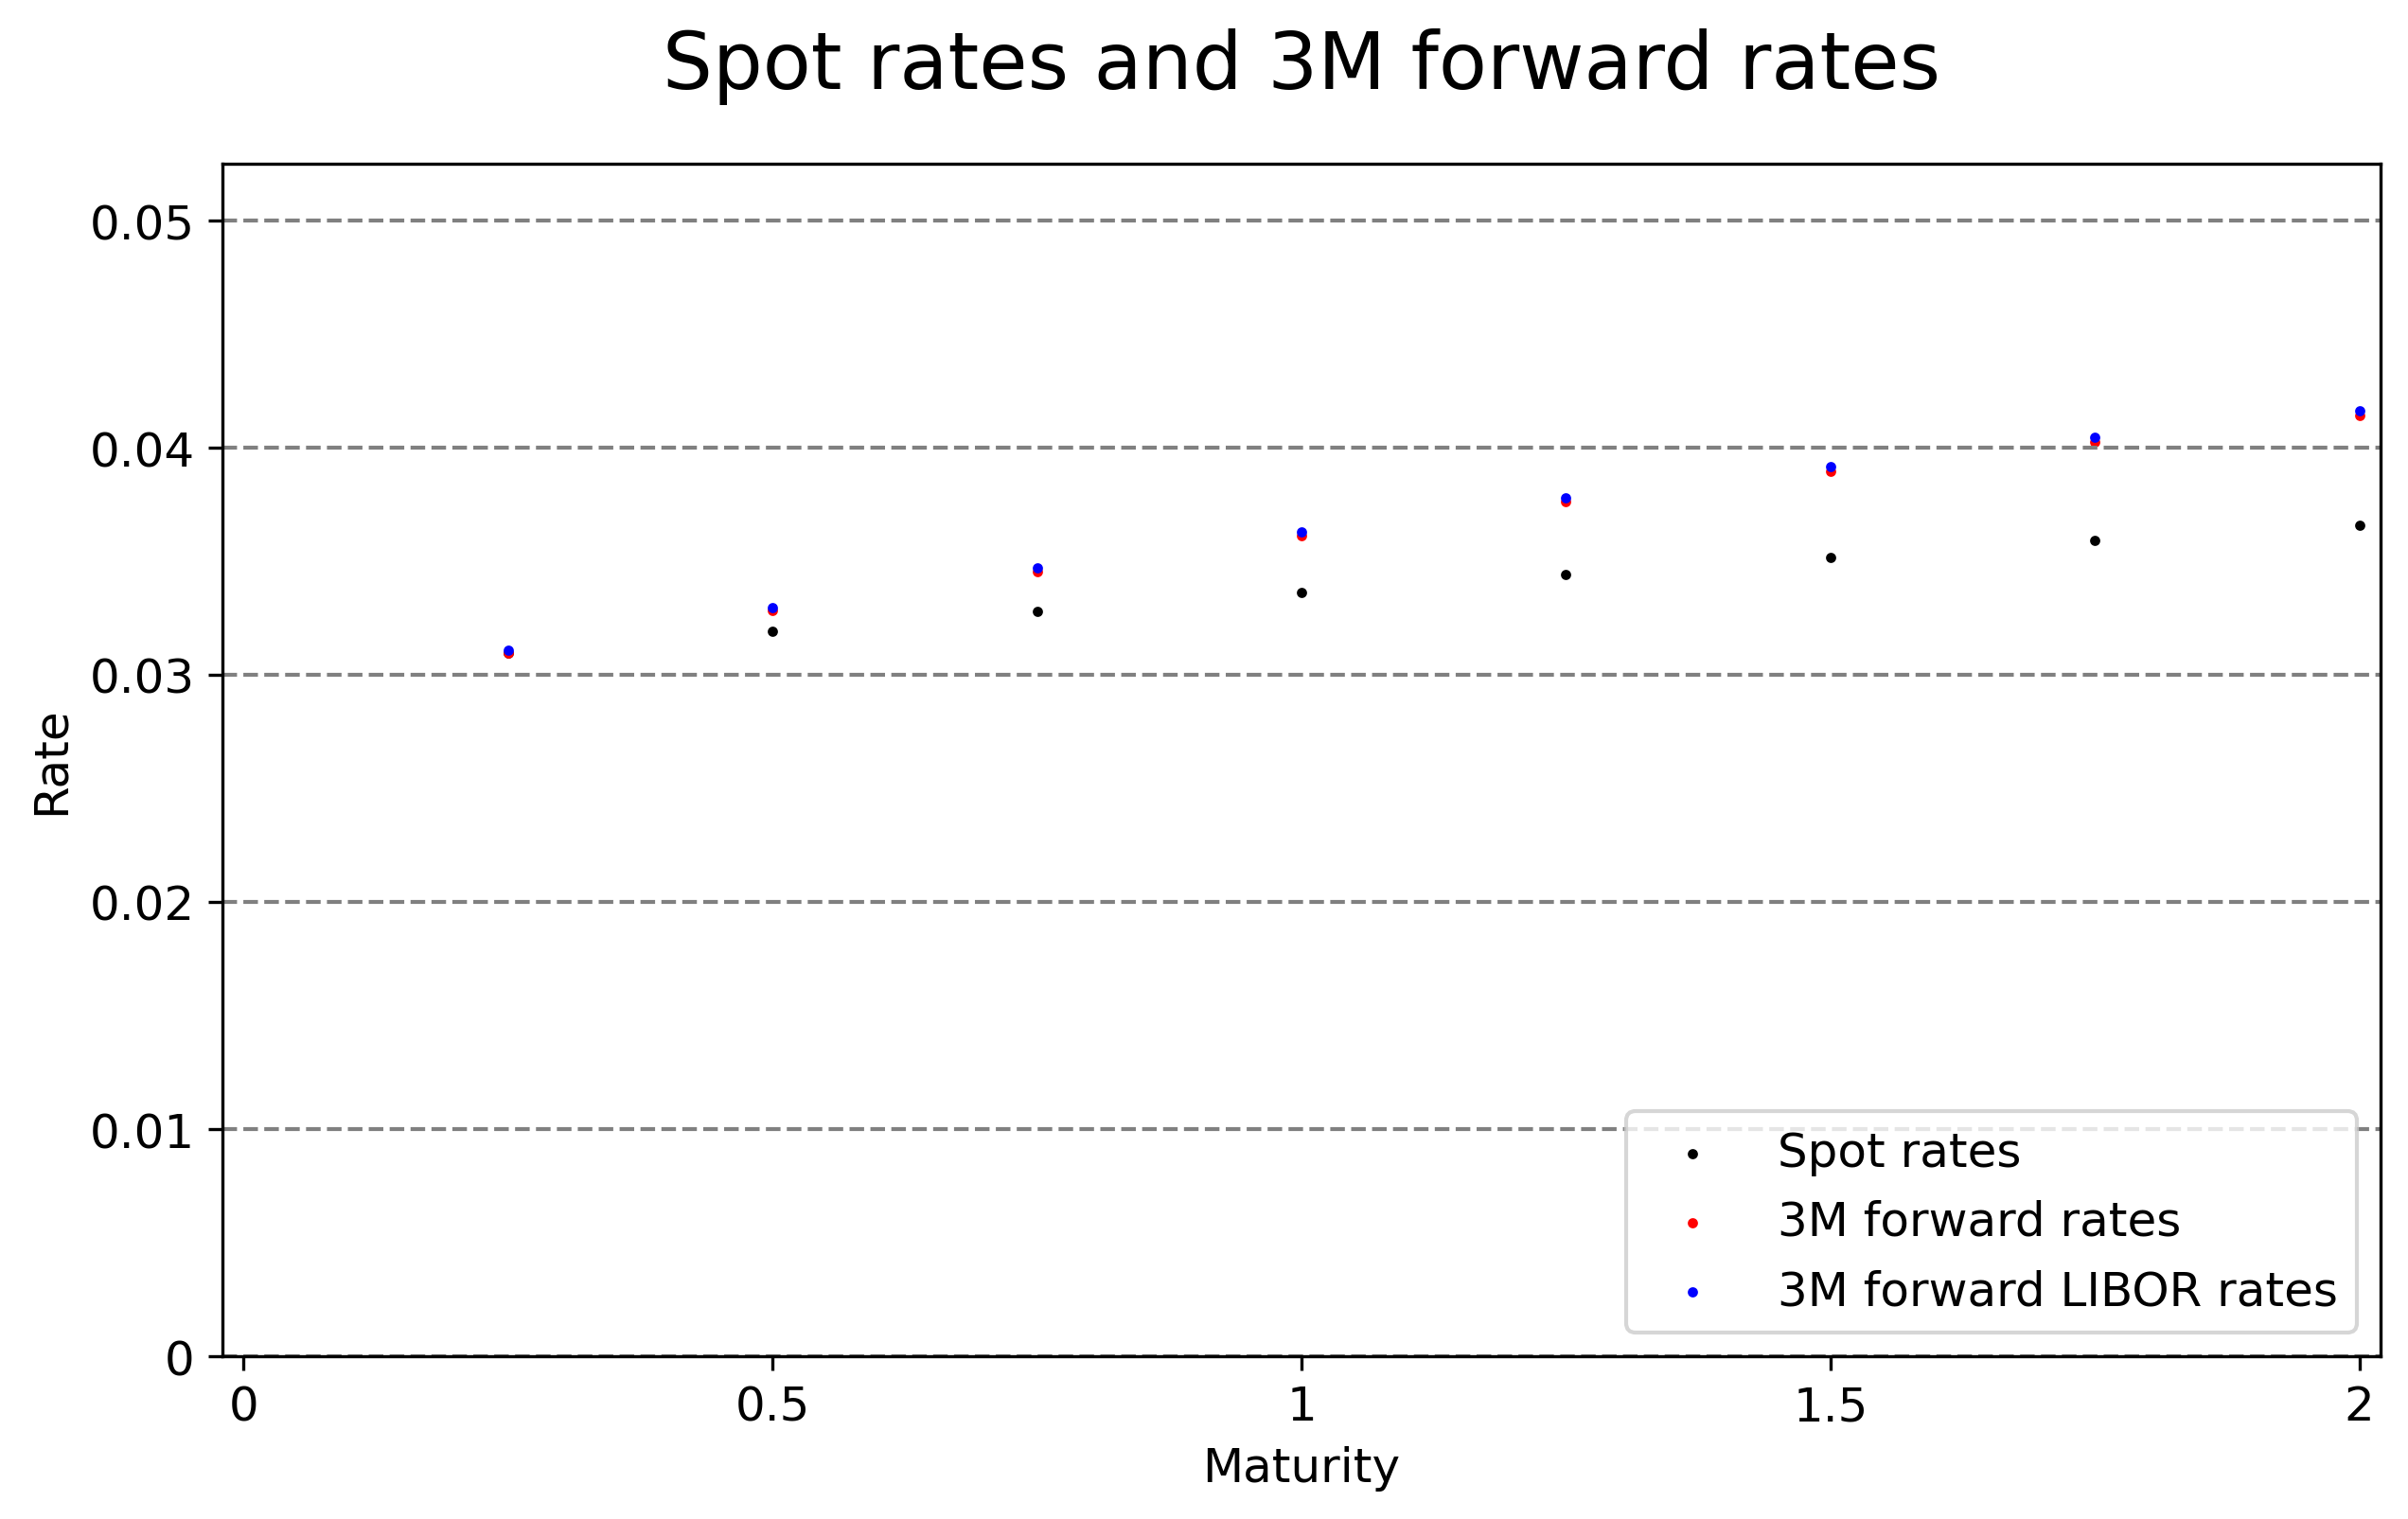

In [8]:
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (10,6))   #
fig.suptitle(f"Spot rates and 3M forward rates", fontsize = 20)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,0.5,1,1.5,2]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 12)
ax.set_xlim([xticks[0]-0.02,xticks[-1]+0.02])
plt.xlabel(f"Maturity",fontsize = 12)
ax.set_yticks([0,0.01,0.02,0.03,0.04,0.05])
ax.set_yticklabels([0,0.01,0.02,0.03,0.04,0.05],fontsize = 12)
for tick in ax.get_yticks():
    ax.axhline(y=tick, color='gray', linestyle='--', linewidth=1)
ax.set_ylim([0,0.0525])
ax.set_ylabel(f"Rate",fontsize = 12)
p1 = ax.scatter(T[1:], r[1:], s = 10, color = 'black', marker = ".",label="Spot rates")
p2 = ax.scatter(T[1:], f_3m[1:], s = 10, color = 'red', marker = ".",label="3M forward rates")
p3 = ax.scatter(T[1:], L[1:], s = 10, color = 'blue', marker = ".",label="3M forward LIBOR rates")

plots = [p1,p2,p3]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="lower right",fontsize = 12)

plt.show()

#### (f) From the viewpoint of the client, discuss the pros and cons of these different two methods of eliminating interest rate risk.

#### (g) Also discuss the pros and cons, if any, seen from the viewpoint of your financial institution. Do any these trades involve risk for the bank? How can the bank minimize/eliminate the risk from offering the client any of the two different solutions

---

# Problem 2
In this problem, we will write a function which computes the Black implied volatility for a caplet with a given price. That is, we will write a function that takes as input: caplet price $C$, time to maturity $T$, strike $R$, tenor $\alpha$, ZCB price $p(0,T)$ and LIBOR rate $L(0; T −\alpha ,T)$ and returns the Black implied volatility of the caplet. We will do this in two different ways

#### (a) Write a function to compute Black implied volatility of a caplet that uses the scipy.minimize and the ’nelder-mead’ method. Apply the function you have written to the data from Problem 1 and make sure that the function works properly by checking that the function recovers the correct implied volatilities from the table above

In [9]:
sigma = 0.25
precision = 1e-10
T, R, alpha, p, L = 2, 0.04, 0.5, 0.92, 0.04
price_caplet = fid.black_caplet_price(sigma,T,R,alpha,p,L,type = 'call')
print(f"price_caplet: {price_caplet} GBP.")

price_caplet: 0.002581818168344541 GBP.


#### (b) Now write a function to compute the implied volatility that only uses the vega of a caplet and no numerical optimization. Is the method you are using guaranteed to converge?. Could you improve the method by also including higher order derivatives of the caplet price with respect to $\sigma$.

In [10]:
iv_caplet = fid.black_caplet_iv(price_caplet,T,R,alpha,p,L, iv0 = 0.2, max_iter = 200, prec = precision)
print(f"implied volatility: {iv_caplet}")

implied volatility: 0.24999999885852425


---

# Problem 3
Suppose present time is set to $t = 0$ and you have market data for zero coupon bond prices and 6M LIBOR caplet prices $C_i$ corresponding to the maturity dates $T_i$, a strike of $R = 0.035$ and a principal of one EUR seen in the table below. Also note that the resettlement (LIBOR fixing announcement) dates are all one period prior. That, is the LIBOR rate serving as the underlying for the $T_i = 1$ caplet is announced at time $T_{i−1} = 0.5$.

In [11]:
M, delta = 9, 1/2 # 9 periods incl 0 (today) of 1/2 year – total of 4 years
T = np.array([m*delta for m in range(M)]) # time in years
C = np.array([np.nan, np.nan, 0.00062138, 0.00193406, 0.00329997, 0.00462232, 0.00588119, 0.00707032, 0.00818548])
p = np.array([1, 0.98530023, 0.96939649, 0.95255338, 0.93499966, 0.91693156, 0.89851614, 0.87989458, 0.86118526])
R = 0.035

#### (a) Find spotrates, 6M forward rates and 6M forward LIBOR rates. Plot these in an appropriate figure

In [12]:
R_spot = fid.spot_rates_from_zcb_prices(T,p)
f = fid.forward_rates_from_zcb_prices(T,p,horizon = 1)
L = fid.forward_libor_rates_from_zcb_prices(T,p,horizon = 1)

print(f"spot rates: \n {R_spot}")
print(f"forward rates: \n {f}")
print(f"forward 6M libor rates: \n {L}")

spot rates: 
 [       nan 0.02961776 0.03108158 0.03240609 0.03360456 0.03468898
 0.0356702  0.03655805 0.03736141]
forward rates: 
 [0.         0.02961776 0.03254539 0.03505511 0.03719996 0.03902666
 0.04057633 0.04188513 0.04298491]
forward 6M libor rates: 
 [0.         0.02983815 0.03281163 0.03536413 0.03754808 0.03940992
 0.04099074 0.0423268  0.04345016]


#### (b) Find the Black implied volatilities  ̄$\sigma_i$ corresponding to these caplet prices and plot the term structure of Black implied volatilities. (You should get numbers ranging between $0.23$ for $T = 1$ and $0.51$ for $T = 4$.)

In [18]:
iv = np.zeros([M])
for i in range(2,M):                        # sigma,T,R,alpha,p,L,type = "call"
    iv[i] = fid.black_caplet_iv(C[i],T[i],R,T[i]-T[i-1],p[i],L[i], iv0 = 0.2, max_iter = 400, prec = 1.0e-15)
print(f'Terms: {T}')
print(f"Term Structure of Implied Volatility: {iv}")
print(f"Implied \sigma**2: {iv[2:]**2}")

Terms: [0.  0.5 1.  1.5 2.  2.5 3.  3.5 4. ]
Term Structure of Implied Volatility: [0.         0.         0.16329721 0.22620295 0.28017271 0.33123007
 0.38106945 0.43034853 0.47936876]
Implied \sigma**2: [0.02666598 0.05116777 0.07849675 0.10971336 0.14521393 0.18519986
 0.22979441]


In the following you are to construct a LIBOR market model based on the Black implied volatilities you have just computed. That is, you will assume a model where LIBOR rates have dynamics of the form 
\begin{align*}
dL_i(t) = L_i(t)\sigma_i(t)dW_i(t), \quad 0 \leq t \leq T_i
\end{align*}
and your job will be to determine the coefficients σi that are consistent with the term structure of Black implied volatilities you have just found. To do this, assume that for the caplet with maturity $T_i$ and resettlement date $T_{i−1}$, $\sigma_i(t)$ is piecewise constant and of the following form
\begin{align*}
\sigma_i(t) = \sigma_{ij} = \beta_{i-j}, \quad \text{for } T_{j−1} < t < T_i, \quad j = 0, 1, . . . , i-1
\end{align*}


#### (c) For $i = 2,...8$ denote $T2 = 1,...,T8 = 4$ and note that there is the following relationship between the Black implied volatilities $\bar{\sigma}_i$ and the diffusion coefficients in the dynamics of LIBOR rates $\sigma_i(t)$ $$\bar{\sigma}_i^2 = \frac{1}{T_{i-1}}\int_{t=0}^{T_{i-1}}\sigma_i^2(s)ds$$ Use this relation to find a linear system of equations relating the $\bar{\sigma}_i$ and the $\beta_{i-j}$ for $i = 2,...,8$

In [22]:
# # LY PS7 Code
#  N = M - 2
# y = iv[2:]**2
# A = 0.5*np.tri(N)
# for i in range(2,M):
#     A[i-2,:] = A[i-2,:]/T[i-1]

# his code this year:
N = M - 2
y = iv[2:]**2*T[2:]
A = 0.5*np.tri(N)
for i in range(2,M):
    A[i-2,:] = A[i-2,:] # seems like a mistake in the code check when sol is out

#### (d) Solve your linear system of equations to find the coefficients $\beta_1,...,\beta_7$.

In [23]:
beta = (np.linalg.solve(A,y))
print(f"beta vector: {beta}")

beta vector: [0.05333196 0.10017136 0.16048366 0.23457982 0.32271675 0.42511547
 0.54195626]


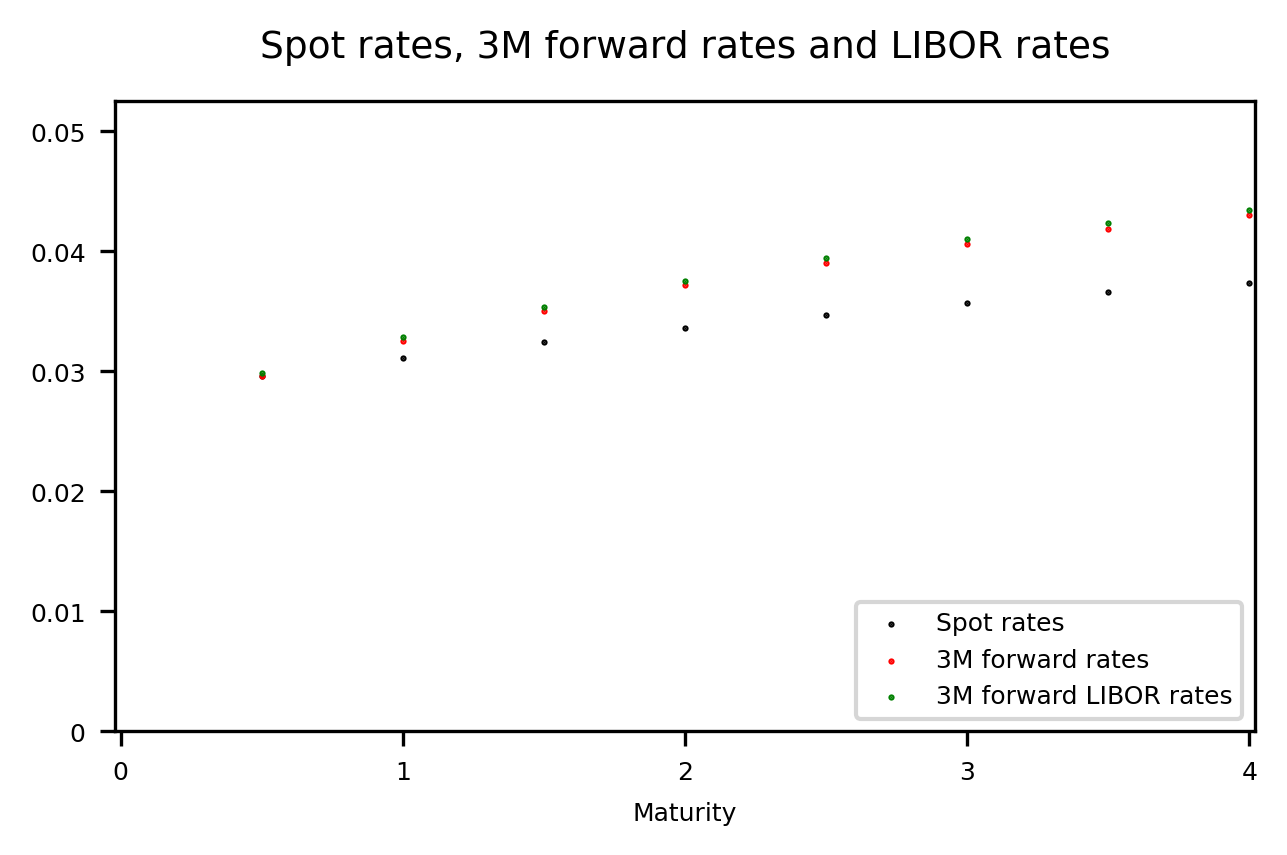

In [16]:
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))   #
fig.suptitle(f"Spot rates, 3M forward rates and LIBOR rates", fontsize = 9)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])

xticks = [0,1,2,3,4]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-0.02,xticks[-1]+0.02])
plt.xlabel(f"Maturity",fontsize = 6)
ax.set_yticks([0,0.01,0.02,0.03,0.04,0.05])
ax.set_yticklabels([0,0.01,0.02,0.03,0.04,0.05],fontsize = 6)
ax.set_ylim([0,0.0525])
# ax.set_ylabel(f"",fontsize = 6)
p1 = ax.scatter(T[1:], R_spot[1:], s = 1, color = 'black', marker = ".",label="Spot rates")
p2 = ax.scatter(T[1:], f[1:], s = 1, color = 'red', marker = ".",label="3M forward rates")
p3 = ax.scatter(T[1:], L[1:], s = 1, color = 'green', marker = ".",label="3M forward LIBOR rates")

plots = [p1,p2,p3]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="lower right",fontsize = 6)

plt.show()